## Goal: To classify the observations with no MoA annotation

In [1]:
# import libraries

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.multioutput import ClassifierChain

# Decision Tree (predict_proba)
from sklearn.tree import DecisionTreeClassifier

# Random Forest (predcit_proba)
from sklearn.ensemble import RandomForestClassifier

# AdaBoost (predict_proba)
from sklearn.ensemble import AdaBoostClassifier

from sklearn.ensemble import GradientBoostingClassifier

# Nearest Neighbors (predict_proba)
from sklearn.neighbors import KNeighborsClassifier

# Neural Net (predict_proba)
from sklearn.neural_network import MLPClassifier

# Linear SVM (predict)
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import jaccard_score, log_loss

import model

### 1. Load and inspect the features and targets of the dense core

In [2]:
# Load the features and targets

X_train_core = pd.read_csv('X_train_core.csv', index_col=0)
X_validate_core = pd.read_csv('X_validate_core.csv', index_col=0)
X_test_core = pd.read_csv('X_test_core.csv', index_col=0)

Y_train_core = pd.read_csv('Y_train_core.csv', index_col=0)
Y_validate_core = pd.read_csv('Y_validate_core.csv', index_col=0)
Y_test_core = pd.read_csv('Y_test_core.csv', index_col=0)

# Print their shapes
X_train_core.shape, X_validate_core.shape, X_test_core.shape, \
Y_train_core.shape, Y_validate_core.shape, Y_test_core.shape

((13558, 50), (3410, 50), (1892, 50), (13558, 206), (3410, 206), (1892, 206))

In [3]:
# Make sure the index match between X and Y

print((X_train_core.index == Y_train_core.index).sum())
print((X_validate_core.index == Y_validate_core.index).sum())
print((X_test_core.index == Y_test_core.index).sum())

13558
3410
1892


In [4]:
# Take a peek at train features
X_train_core.head(2)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
sig_id,,,,,,,,,,,,,,,,,,,,,
id_887911684,-0.113079,-0.126488,-0.045746,-0.065418,0.009277,0.058472,-0.015255,0.286149,-0.071498,0.029081,...,-0.004725,-0.046098,-0.000499,0.032700,-0.090504,0.031419,-0.122123,0.024048,-0.122287,-0.012305
id_294d38ce4,-0.239770,-0.242513,0.469707,0.132345,-0.079247,0.053615,-0.062062,0.159616,-0.169681,0.026081,...,-0.023376,0.004647,0.002614,0.044699,0.061037,-0.002453,-0.014456,-0.020474,0.008282,0.037586


In [5]:
# Take a peek at validate features
Y_train_core.head(2)

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_887911684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_294d38ce4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


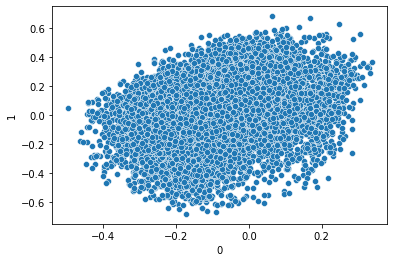

In [6]:
# Quick viz to confirm the correct separation

sns.scatterplot(data=X_train_core, x='0', y='1')
plt.show()

**Takeaways**: The cluster 'dense core' are successfully substracted from train/validate/test.

### 2. Explore the target variable

In [8]:
# Compute the counts of MoA annotations for the sig_id and 
# store the number in a new column

Y_train_core['label_counts'] = Y_train_core.sum(axis=1)
Y_validate_core['label_counts'] = Y_validate_core.sum(axis=1)
Y_test_core['label_counts'] = Y_test_core.sum(axis=1)

# Take a peek at the Y_train_core
Y_train_core.head()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,label_counts
sig_id,,,,,,,,,,,,,,,,,,,,,
id_887911684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_294d38ce4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_b12cf3d9c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id_d8f5ca938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2
id_c4eaa645d,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
# Compute the percentage of sig_ids with no MoA annotation in train

pd.concat([Y_train_core.label_counts.value_counts(),
           Y_train_core.label_counts.value_counts(normalize=True)], axis=1).sort_index()

,label_counts,label_counts
0,4974,0.366868
1,7815,0.576412
2,532,0.039239
3,204,0.015046
4,29,0.002139
5,4,0.000295


In [11]:
# Compute the percentage of sig_ids with no MoA annotation in validate

pd.concat([Y_validate_core.label_counts.value_counts(),
           Y_validate_core.label_counts.value_counts(normalize=True)], axis=1).sort_index()

,label_counts,label_counts
0,1228,0.360117
1,2009,0.589150
2,114,0.033431
3,45,0.013196
4,11,0.003226
5,3,0.000880


In [13]:
# Compute the percentage of sig_ids with no MoA annotation in validate

pd.concat([Y_test_core.label_counts.value_counts(),
           Y_test_core.label_counts.value_counts(normalize=True)], axis=1).sort_index()

,label_counts,label_counts
0,646,0.341438
1,1146,0.605708
2,55,0.029070
3,37,0.019556
4,8,0.004228


**Takeaways**
- About 35% of the observations has no MoA annotations.
- Picking them out first will greatly reduce the background noise for modeling the observations with MoA labels. 

In [16]:
# Conver the label_counts to a binary categorical variable

Y_train_core['label'] = Y_train_core.label_counts.apply(lambda i: 0 if i == 0 else 1)
Y_validate_core['label'] = Y_validate_core.label_counts.apply(lambda i: 0 if i == 0 else 1)
Y_test_core['label'] = Y_test_core.label_counts.apply(lambda i: 0 if i == 0 else 1)

# Take a peek at a random sample of Y_train_core
Y_train_core.sample(5)

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,label_counts,label
sig_id,,,,,,,,,,,,,,,,,,,,,
id_baecfb8c4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
id_f1e48205c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_38ee0e695,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_e2c4c8025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
id_60433eb5e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Create the target variables

y_train = Y_train_core.label
y_validate = Y_validate_core.label
y_test = Y_test_core.label

# Take a look at y_train
y_train.head()

sig_id
id_887911684    0
id_294d38ce4    0
id_b12cf3d9c    1
id_d8f5ca938    1
id_c4eaa645d    1
Name: label, dtype: int64

In [19]:
# Make sure the index match between X and y

print((X_train_core.index == y_train.index).sum())
print((X_validate_core.index == y_validate.index).sum())
print((X_test_core.index == y_test.index).sum())

13558
3410
1892


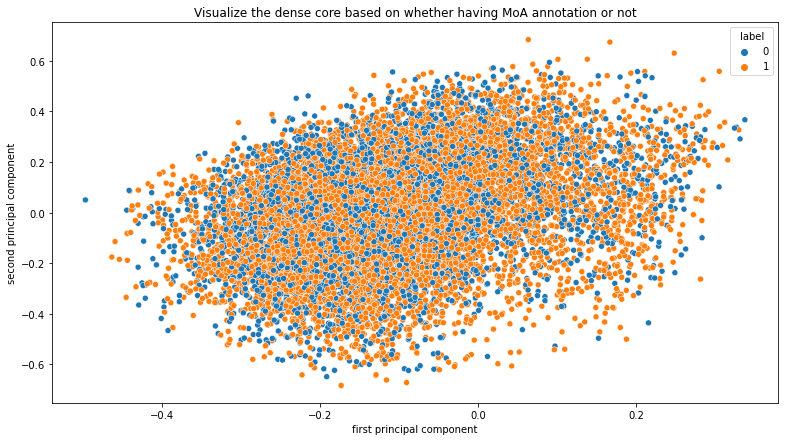

In [24]:
# Combine the features and the target variable in the train dataset
train = pd.concat([X_train_core, y_train], axis=1)

# Visualize the train dataset

plt.figure(figsize=(13,7))
sns.scatterplot(data=train, x='0', y='1', hue='label')
plt.title('Visualize the dense core based on whether having MoA annotation or not')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

**Takeaways**
- The new target variable 'label' is successfully created for train/validate/test.
- The following section will focus on the classification of whether the sig_id has a label or not. 
- The peformance metrics will be accuracy, precision, and recall.

### 3. Modeling - Binary Classification

#### 3-1. Compute baseline accuracy: 37%

In [20]:
y_train.value_counts(normalize=True)

1    0.633132
0    0.366868
Name: label, dtype: float64

#### 3-2 Modeling on Train

In [ ]:
# Create a list of names of the classifiers
names = ['LogisticRegression',
         'Sigmoid SVM', 
         'Poly 2 SVM',
         'AdaBoost, max_depth=1, 100',
         'AdaBoost, max_depth=2, 100',
         'AdaBoost, max_depth=3, 100',
         'AdaBoost, max_depth=4, 100',
         'AdaBoost, max_depth=5, 100', 
         'Gradient Boosting, 0.1, 100',
         'Gradient Boosting, 0.1, 200',
         'Gradient Boosting, 1.0, 100',
         'Gradient Boosting, 1.0, 200']